# Using A3TGCN for speed prediction of the traffic

The details about the data is shown in the notebook
https://github.com/mhmdrdwn/traffic/blob/main/notebooks/tgcn-seoul-dataset.ipynb

The data: https://github.com/yuyolshin/SeoulSpeedData

In [1]:
from IPython.display import clear_output
from tqdm import tqdm

In [2]:
import torch
pt_version = torch.__version__

!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-geometric
!pip install torch-geometric-temporal
clear_output()

## Using Seoul Urban Core Data

In [3]:
import numpy as np
import pandas as pd

def read_data(features_csv, adj_csv):
    urban_core_speeds = pd.read_csv(features_csv, header=None)
    adj_matrix_df = pd.read_csv(adj_csv, header=None)
    adj_matrix = np.array(adj_matrix_df)

    speeds_df = urban_core_speeds.iloc[:, 7:]
    speeds = np.array(speeds_df)
    
    return adj_matrix_df, urban_core_speeds, adj_matrix, speeds

adj_matrix_df, urban_core_speeds, adj_matrix, speeds = read_data(
    '../input/seoul-speed-data/urban-core.csv', 
    '../input/seoul-speed-data/Adj(urban-core).csv')

In [4]:
"""Train test split the data"""

test_split = 6 * 12 * 24 # 6 days X 12 measurements per hour X 24 hours
val_split = 2 * 12 * 24

split = speeds.shape[1] - test_split
train_data = speeds[:, :split-int(val_split)]
test_data = speeds[:, split:]
val_data = speeds[:, split-int(val_split):split]

print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)
print("Val data: ", val_data.shape)

Train data:  (304, 6336)
Test data:  (304, 1728)
Val data:  (304, 576)


In [5]:
"""Min max standardizing the data"""
max_speed = train_data.max()
min_speed = train_data.min()

train_data = (train_data - min_speed) / (max_speed - min_speed)
test_data = (test_data - min_speed) / (max_speed - min_speed)
val_data = (val_data - min_speed) / (max_speed - min_speed)

train_data.shape, test_data.shape, val_data.shape

((304, 6336), (304, 1728), (304, 576))

Here we build the features and labels of the time series, The features vectors are of length 10 while the prediction is the next step in the sequence. The model can predict a sequence too where the preiction length can be more than 10. 

In [21]:
"""Ref: https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html"""

sequence_len = 10
prediction_len = 5

def build_features_labels(sequence_len, prediction_len, train_data, test_data, val_data):
    X_train, Y_train, X_test, Y_test, X_val, Y_val = [], [], [], [], [], []

    for i in range(train_data.shape[1] - int(sequence_len + prediction_len - 1)):
        a = train_data[:, i : i + sequence_len + prediction_len]
        X_train.append(a[:, :sequence_len])
        Y_train.append(a[:, sequence_len:sequence_len+prediction_len])

    for i in range(test_data.shape[1] - int(sequence_len + prediction_len - 1)):
        b = test_data[:, i : i + sequence_len + prediction_len]
        X_test.append(b[:, :sequence_len])
        Y_test.append(b[:, sequence_len:sequence_len+prediction_len])
        
    for i in range(val_data.shape[1] - int(sequence_len + prediction_len - 1)):
        b = val_data[:, i : i + sequence_len + prediction_len]
        X_val.append(b[:, :sequence_len])
        Y_val.append(b[:, sequence_len:sequence_len+prediction_len])
        
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    X_val = np.array(X_val)
    Y_val = np.array(Y_val)
    
    return X_train, Y_train, X_test, Y_test, X_val, Y_val

X_train, Y_train, X_test, Y_test, X_val, Y_val = build_features_labels(sequence_len, 
                                                                       prediction_len, 
                                                                       train_data, 
                                                                       test_data, 
                                                                       val_data)

X_train_shape = X_train.shape
X_test_shape = X_test.shape
X_val_shape = X_val.shape
Y_train_shape = Y_train.shape
Y_test_shape = Y_test.shape
Y_val_shape = Y_val.shape

X_train = X_train.reshape(X_train_shape[0], X_train_shape[1], 1, X_train_shape[2])
X_test = X_test.reshape(X_test_shape[0], X_test_shape[1], 1, X_test_shape[2])
X_val = X_val.reshape(X_val_shape[0], X_val_shape[1], 1, X_val_shape[2])
Y_train = Y_train.reshape(Y_train_shape[0], Y_train_shape[1],Y_train_shape[2])
Y_test = Y_test.reshape(Y_test_shape[0], Y_test_shape[1], Y_test_shape[2])
Y_val = Y_val.reshape(Y_val_shape[0], Y_val_shape[1], Y_val_shape[2])


print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

(6322, 304, 1, 10)
(6322, 304, 5)
(1714, 304, 1, 10)
(1714, 304, 5)
(562, 304, 1, 10)
(562, 304, 5)


In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

edges = np.nonzero(adj_matrix)
edges = np.vstack([edges, adj_matrix[edges]])
edge_index = edges[:2, :].astype(float)
edge_attr = edges[2, :].astype(float)
print('Edges shape: ', edge_index.shape, ', Attr shape: ',edge_attr.shape)

edge_index = torch.from_numpy(edge_index).type(torch.long).to(device)

Edges shape:  (2, 1696) , Attr shape:  (1696,)


Another appropriate way is to convert the input data into graph temporal object to feed to the model in the torch geometric library, The object we use here is Static Graph Temporal Signal. There are other object that are Dynamic. In Dynamic, we expect that the graph changes over time but here the graph topology does not change over time. We take the adjacency matrix and get the indices where there are connections between nodes and call it edge index. Edge attribute is the value of the connection between nodes. Those two are passed along with the traditional X and y (X is 10 steps in time series whie y is the next 10 steps in the series).

In [8]:
#from torch_geometric_temporal.signal import StaticGraphTemporalSignal
#train_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_train, Y_train)
#test_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_test, Y_test)
#val_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_val, Y_val)

In [9]:
batch_size=32

In [22]:
train_input = np.array(X_train) 
train_target = np.array(Y_train) 
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(device)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(device) 
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, drop_last=True)

val_input = np.array(X_val) 
val_target = np.array(Y_val)
val_x_tensor = torch.from_numpy(val_input).type(torch.FloatTensor).to(device)
val_target_tensor = torch.from_numpy(val_target).type(torch.FloatTensor).to(device) 
val_dataset_new = torch.utils.data.TensorDataset(val_x_tensor, val_target_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset_new, batch_size=batch_size, drop_last=True)

test_input = np.array(X_test)
test_target = np.array(Y_test) 
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(device)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(device)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, drop_last=True)

The A3TGCN network (Attention Temporal Graph Neural Network) original article is https://arxiv.org/abs/2006.11583, A3TGCN is an extention of TGCN by adding the attention mechanism to assemble global temporal information to improve prediction accuracy. TGCN does not consider Long-term dependencies and the importance of different time points cannot be distinguished (No attention).

So GCN captures topology information, LSTM or GRU captures tempral information and attention captures global pattern. A3TGCN attention (soft attention) is used to learn the importance of traffic information at each moment. The result from LSTM or GRU are hidden states at different time steps. A scoring function (i.e. MLP) is designed to calculate the score/weight of each hidden state. An attention function is designed to calculate the context vector that covers the global traffic variation. And the final output results are obtained using the context vector.

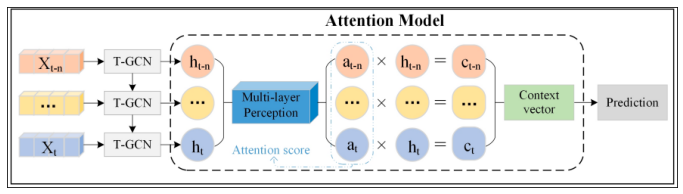

In [11]:
"""Ref: https://arxiv.org/abs/2006.11583"""
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(12,12))
plt.imshow(mpimg.imread('https://raw.githubusercontent.com/mhmdrdwn/traffic/main/plots/a3tgcn.png'))
plt.tick_params(axis='both', which='both', bottom=False, top=False, 
                left=False,right=False, labelleft=False, labelbottom=False) 
plt.show()

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN2

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class A3TGCNModel(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(A3TGCNModel, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods,
                           batch_size=batch_size)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h
    
"""Ref: https://colab.research.google.com/drive/132hNQ0voOtTVk3I4scbD3lgmPTQub0KR?usp=sharing#scrollTo=7kOvaOrps2oe"""

'Ref: https://colab.research.google.com/drive/132hNQ0voOtTVk3I4scbD3lgmPTQub0KR?usp=sharing#scrollTo=7kOvaOrps2oe'

In [28]:
def evaluate_model(model, val_loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in val_loader:
            y_hat = model(x, edge_index)
            loss = loss_func(y_hat, y) 
            losses.append(loss.item())
    mean_loss = np.mean(losses)
    print("Val MSE: {:.4f}".format(mean_loss))
    return mean_loss

In [41]:
loss_func = torch.nn.MSELoss()

model = A3TGCNModel(node_features=1, periods=5, batch_size=batch_size).to(device)
# periods = 10 as we predict the next 10 step after the sequence
# Node features is 1 as we consider only graph index
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_losses, val_losses = [], []

for epoch in range(5): 
    model.train()
    print('Epoch: ', epoch+1)
    print('==========')
    
    losses = []
    for x, y in tqdm(train_loader):
        y_hat = model(x, edge_index)
        loss = loss_func(y_hat, y) 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.item())
    
    mean_loss = sum(losses)/len(losses)
    print("Train MSE: {:.4f}".format(mean_loss))
    train_losses.append(mean_loss)
    
    val_loss = evaluate_model(model, val_loader)
    val_losses.append(val_loss)

Epoch:  1


100%|██████████| 197/197 [00:53<00:00,  3.67it/s]


Train MSE: 0.0104
Val MSE: 0.0064
Epoch:  2


100%|██████████| 197/197 [00:54<00:00,  3.64it/s]


Train MSE: 0.0066
Val MSE: 0.0064
Epoch:  3


100%|██████████| 197/197 [00:54<00:00,  3.60it/s]


Train MSE: 0.0066
Val MSE: 0.0064
Epoch:  4


100%|██████████| 197/197 [00:54<00:00,  3.62it/s]


Train MSE: 0.0066
Val MSE: 0.0064
Epoch:  5


100%|██████████| 197/197 [00:54<00:00,  3.60it/s]


Train MSE: 0.0065
Val MSE: 0.0064


In [42]:
"""plt.figure(figsize=(10,7))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Val Loss')
plt.legend(loc="upper left")
plt.show()"""

'plt.figure(figsize=(10,7))\nplt.plot(range(len(train_losses)), train_losses, label=\'Train Loss\')\nplt.plot(range(len(val_losses)), val_losses, label=\'Val Loss\')\nplt.legend(loc="upper left")\nplt.show()'

In [43]:
"""Make predictions for test data"""
model.eval()
y_preds = list()
y_true = list()

for x, y in test_loader:

    y = y.cpu().numpy().reshape(-1)
    y_pred = model(x, edge_index).view(len(x), -1).cpu().detach().numpy().reshape(-1)

    y = np.array(y * max_speed)
    y_pred = np.array((y_pred) * max_speed)
    y_preds.extend(list(y_pred))
    y_true.extend(list(y))
    
y_preds = np.array(y_preds)
y_true = np.array(y_true)
y_preds = y_preds.reshape(int(y_preds.shape[0]/(304*5)), 304, 5)
y_true = y_true.reshape(int(y_true.shape[0]/(304*5)), 304, 5)

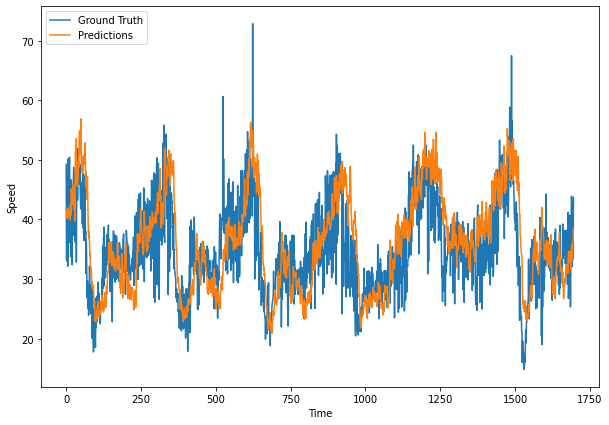

In [44]:
"""show one sensor time series"""
y_sample = y_true[:, 2, 0]
y_pred_sample = y_preds[:, 2, 0]

plt.figure(figsize=(10,7))
plt.plot(range(len(y_sample)), y_sample, label='Ground Truth')
plt.plot(range(len(y_pred_sample)), y_pred_sample, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend(loc="upper left")
plt.show()

In [45]:
"""Overall evaluation the predictions of the test data"""
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true +=  0.00000001 #add small values to true velocities to avoid division by zeros
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('RMSE: ', np.sqrt(mean_squared_error(y_true.flatten(), y_preds.flatten())))
print('MAE: ', mean_absolute_error(y_true.flatten(), y_preds.flatten()))
print('MAPE: ', mean_absolute_percentage_error(y_true.flatten(), y_preds.flatten()), "%")

RMSE:  7.8240843
MAE:  5.900248
MAPE:  26.943868398666382 %


# References:

- Jiandong Bai, Jiawei Zhu, Yujiao Song, Ling Zhao, Zhixiang Hou, Ronghua Du, Haifeng Li: A3T-GCN: Attention Temporal Graph Convolutional Network for Traffic Forecasting. ISPRS Int. J. Geo Inf. 10(7): 485 (2021)

- Shin, Y., & Yoon, Y. (2020). Incorporating dynamicity of transportation network with multi-weight traffic graph convolutional network for traffic forecasting. IEEE Transactions on Intelligent Transportation Systems.

- https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html


- https://colab.research.google.com/drive/132hNQ0voOtTVk3I4scbD3lgmPTQub0KR?usp=sharing#scrollTo=7kOvaOrps2oe